In [ ]:
from PIL import Image, ImageFilter, ImageFont, ImageDraw

import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Load word locations
def load_word_locations(file_path):
    word_locations = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split()
            line_id = parts[0]
            words = [tuple(map(int, w.split('-'))) for w in parts[2].split('|')]
            word_locations[line_id] = words
    return word_locations

# Load transcriptions
def load_transcriptions(file_path):
    transcriptions = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split()
            line_id = parts[0]
            spellings = parts[1].split('|')
            letters = [spelling.replace('-', '') for spelling in spellings]
            transcriptions[line_id] = {'letters': letters}
    return transcriptions

# Read and extract words from an image
def extract_words_from_image(image_path, words):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    word_images = []
    for start, end in words:
        word_img = img[:, start:end]  # Crop word region
        word_img_dilated = Image.fromarray((word_img).astype(np.uint8))
        word_images.append(np.array(word_img_dilated))
    return word_images

# Main function
def get_image_and_transcription(line_id, image_folder, word_location_file, transcription_file):
    word_locations = load_word_locations(word_location_file)
    transcriptions = load_transcriptions(transcription_file)
    words = word_locations[line_id]
    image_path = f"{image_folder}\\{line_id}.png"
    word_images = extract_words_from_image(image_path, words)
    spellings = transcriptions.get(line_id, {}).get('letters', [])
    return word_images, spellings

In [4]:
def create_background():
    '''
    Create background simulating degradation (noise for texture, blur)
    '''
    # Set light tan-yellowish-beige color for parchment-like background 
    base_color = np.random.randint(200, 230, size=3) 
    base_color[0] = np.random.randint(200, 250) 
    base_color[1] = np.random.randint(220, 230) 
    base_color[2] = np.random.randint(150, 190) 
    
    # Create background
    img = np.array(Image.new('RGB', (350, 350), color=tuple(base_color)))

    # Add random noise
    noise_strength = np.random.randint(1, 50)
    noise = np.random.randint(-noise_strength, noise_strength, size=(350, 350, 3)) 
    noisy_img = np.clip(img + noise, 0, 255) 

     # Add random salt-and-pepper noise
    salt_pepper_percentage = np.random.uniform(0, 0.04)  # Random percentage (1% to 4%)
    num_pixels = int(salt_pepper_percentage * 350 * 350)

    salt_coords = (np.random.randint(0, 350, num_pixels), np.random.randint(0, 350, num_pixels))
    noisy_img[salt_coords[0], salt_coords[1]] = [255, 255, 255]  # Apply salt noise (white pixels)
    
    pepper_coords = (np.random.randint(0, 350, num_pixels), np.random.randint(0, 350, num_pixels))
    noisy_img[pepper_coords[0], pepper_coords[1]] = [0, 0, 0] 

    # Add random Gaussian noise
    if np.random.rand() > 0.5: 
        blur_radius = np.random.uniform(1, 3) 
        noisy_img = Image.fromarray(noisy_img.astype(np.uint8)).filter(ImageFilter.GaussianBlur(radius=blur_radius))
        noisy_img = np.array(noisy_img)

    return noisy_img


In [5]:
def add_text(word_images, spellings):
    '''
    Combine background and text in patch
    '''
    combined = []

    for idx in range(len(word_images)):
        word = Image.fromarray(word_images[idx].astype(np.uint8))
        transcription = spellings[idx]
        
        # Rotate image
        word = word.rotate(random.uniform(-20, 20), resample=Image.BICUBIC, fillcolor=255)
        word_width, word_height= word.size

        # Create background
        background_arr = create_background()

        # Create transparent background for text in word image
        black_mask = np.array(word) < 100  
        word_rgba = np.zeros((word_height, word_width, 4), dtype=np.uint8)  
        word_rgba[black_mask] = [0, 0, 0, 255] 
        word_rgba[~black_mask] = [0, 0, 0, 0] 

        # Place the word in the middle of the image
        x_pos = (350 - word_width) // 2
        y_pos = (350 - word_height) // 2
        if x_pos + word_width > 350:
            x_pos = 350 - word_width  
        if y_pos + word_height > 350:
            y_pos = 350 - word_height 
        
        # Set a random dark gray color for the numbers
        image_text_color_value = np.random.randint(0, 50) 
        image_text_color = np.array([image_text_color_value, image_text_color_value, image_text_color_value])
        word_rgba[black_mask] = np.concatenate([image_text_color, [255]])

        try:
            # Add the word to the background, skip if too large
            background_arr[y_pos:y_pos + word_height, x_pos:x_pos + word_width] = np.where(
            word_rgba[:, :, 3:] == 0,  
            background_arr[y_pos:y_pos + word_height, x_pos:x_pos + word_width], 
            word_rgba[:, :, :3])
        except ValueError:
            print("Word image too large")
            continue
        
        # Create white background for the target image
        mask = np.ones((350, 350, 3), dtype=np.uint8) * 255

        # Add the word to the background, already skipped if too large
        mask[y_pos:y_pos + word_height, x_pos:x_pos + word_width] = np.where(
        word_rgba[:, :, 3:] == 0,  
        mask[y_pos:y_pos + word_height, x_pos:x_pos + word_width], 
        word_rgba[:, :, :3])
        mask_arr = mask.astype(np.uint8)

        # Resize images 
        mask_arr_resized = Image.fromarray(cv2.resize(mask_arr, (224,224), interpolation=cv2.INTER_AREA).astype(np.uint8))
        background_arr = background_arr.astype(np.uint8)
        background_arr_resized = cv2.resize(background_arr, (224,224), interpolation=cv2.INTER_AREA)
        
        combined.append((background_arr_resized, mask_arr_resized, transcription))

    return combined

In [ ]:
def save_img(final_img, patch, image_name, train):
    """
    Save the final image with a new filename.
    """    
    new_filename = f"{image_name}.png"

    base_dir = r"...\synthetic_data\SaintGall"
    dataset_type = "train" if train else "test"
    
    combined_path = os.path.join(base_dir, dataset_type, "combined", new_filename)
    under_path = os.path.join(base_dir, dataset_type, "undertext", new_filename)

    os.makedirs(os.path.dirname(combined_path), exist_ok=True)
    os.makedirs(os.path.dirname(under_path), exist_ok=True)

    final_img.save(combined_path)
    patch.save(under_path)

In [ ]:
# Define paths
folder_path = r"...\saintgalldb-v1.0\saintgalldb-v1.0\data\line_images_normalized"
word_location_file = r"...\saintgalldb-v1.0\saintgalldb-v1.0\ground_truth\word_location.txt"
transcription_file = r"...\saintgalldb-v1.0\saintgalldb-v1.0\ground_truth\transcription.txt"

# Ensure no data leakage between train and test
train_numbers = [f"{num}" for num in range(23, 60) if num not in {51, 52, 53}]
test_numbers = [f"{num}" for num in range(60, 65)]
train = True

#data = [] # For plotting
for image_name in os.listdir(folder_path):

    page_number = image_name.split('-')[1][-2:]
    if page_number in train_numbers or page_number in test_numbers:
        # Extract word image and its transcription
        word_images, transcription = get_image_and_transcription(f"csg562-0{page_number}-{image_name.split('-')[2].split('.')[0]}", folder_path, word_location_file, transcription_file)

        # Add the text to a noisy background
        combined_imgs = add_text(word_images, transcription)

        for idx, (image, mask, transcription) in enumerate(combined_imgs):  
                
            if page_number in train_numbers:
                valid_numbers = train_numbers
                train = True
            elif page_number in test_numbers:
                valid_numbers = test_numbers
                train = False

            # Set a random font for the over-text
            fonts_dir = r"C:\Windows\Fonts"
            font_files = [f for f in os.listdir(fonts_dir) if f.endswith('.ttf') or f.endswith('.otf')]
            selected_font = random.choice(font_files)
            
            # Set a random font size between 30 and 40 and random font color between 0 and 50
            font_size = random.randint(30, 40) 
            gray_value = np.random.randint(0, 50)

            # Create a random string with random characters
            random_string = ''.join(random.choice('ABCDEFGHIJKLMNOPQRSTUVWXYZ') for _ in range(random.randint(4, 7)))
            font = ImageFont.truetype(os.path.join(fonts_dir, selected_font), font_size)

            # Get text size for centering
            bbox = text_draw.textbbox((0, 0), random_string, font=font)
            text_width = bbox[2] - bbox[0]
            text_height = bbox[3] - bbox[1]
            x = (224 - text_width) // 2
            y = (224 - text_height) // 2

            # Place the character in the middle of a transparent image
            top_img = Image.new("RGBA", (224, 224), (255, 255, 255, 0))  
            text_draw = ImageDraw.Draw(top_img)  
            text_draw.text((x, y), random_string, font=font, fill=(gray_value, gray_value, gray_value))

            # Rotate the character image
            top_rotated = top_img.rotate(random.uniform(-20, 20), resample=Image.BICUBIC)
            
            # Paste the over-text to the background+under-text image
            image = Image.fromarray(image.astype(np.uint8))
            image.paste(top_rotated, (0, 0), top_rotated) 
            
            # Set filename
            filename = f'page{page_number[-2:]}_line{image_name.split('-')[2].split('.')[0]}-{transcription}'

        #if page_number == "24": # For plotting
        #    break
        #else:
        #    data.append([image, mask, transcription])
                
            # Save the combined and under-text
            save_img(image, mask, filename, train)

In [ ]:
'''
Tuning data creation for AttentionHTR only using train_dataset for train and test (use page 23-56, ignore 57-65)
''' 
# Define paths
folder_path = r"...\saintgalldb-v1.0\saintgalldb-v1.0\data\line_images_normalized"
word_location_file = r"...\saintgalldb-v1.0\saintgalldb-v1.0\ground_truth\word_location.txt"
transcription_file = r"...\saintgalldb-v1.0\saintgalldb-v1.0\ground_truth\transcription.txt"

train_numbers = [f"{num}" for num in range(23, 56) if num not in {51, 52, 53}]
test_numbers = [f"{num}" for num in range(56, 60)]

for image_name in os.listdir(folder_path):
    page_number = image_name.split('-')[1][-2:]

    if page_number in train_numbers or page_number in test_numbers:
        word_images, transcription = get_image_and_transcription(f"csg562-0{page_number}-{image_name.split('-')[2].split('.')[0]}", folder_path, word_location_file, transcription_file)
        combined_imgs = add_text(word_images, transcription)

        for idx, (image, mask, transcription) in enumerate(combined_imgs):  
            filename = f'page{page_number[-2:]}_line{image_name.split('-')[2].split('.')[0]}-{transcription}.png'
            
            if page_number in train_numbers:
                base_dir = r"...\synthetic_data\AttentionHTR_SaintGall\train"
                path = os.path.join(base_dir, filename)
                os.makedirs(os.path.dirname(path), exist_ok=True)
                mask.save(path)
                
            elif page_number in test_numbers:
                base_dir = r"...\synthetic_data\AttentionHTR_SaintGall\test"
                path = os.path.join(base_dir, filename)
                os.makedirs(os.path.dirname(path), exist_ok=True)
                mask.save(path)

In [30]:
def plot_SaintGall(data, idx1, idx2, idx3):
    '''
    Plot synthetic SaintGall examples
    '''
    # Fetch the data (undertext_image, combined_img, label) from dataset
    image_1, undertext_1, label_1 = data[idx1]
    image_2, undertext_2, label_2 = data[idx2]
    image_3, undertext_3, label_3 = data[idx3]

    plt.figure(figsize=(6, 3))
    plt.subplot(2, 3, 1)
    plt.imshow(image_1)
    plt.title(f"Combined Image")
    plt.axis('off')
    plt.subplot(2, 3, 2)
    plt.imshow(image_2)
    plt.title(f"Combined Image")
    plt.axis('off')
    plt.subplot(2, 3, 3)
    plt.imshow(image_3)
    plt.title(f"Combined Image")
    plt.axis('off')
    plt.subplot(2, 3, 4)
    plt.imshow(undertext_1, cmap="gray")
    plt.title(f"Label: {label_1}")
    plt.axis('off')
    plt.subplot(2, 3, 5)
    plt.imshow(undertext_2, cmap="gray")
    plt.title(f"Label: {label_2}")
    plt.axis('off')
    plt.subplot(2, 3, 6)
    plt.imshow(undertext_3, cmap="gray")
    plt.title(f"Label: {label_3}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

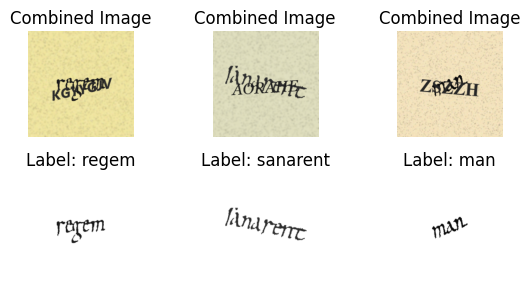

In [51]:
plot_SaintGall(data, idx1=1, idx2=6, idx3=8)